Use this notebook to run allocation strategies on available equity data.

Download from the following:
- https://www.kaggle.com/ehallmar/daily-historical-stock-prices-1970-2018

In [25]:
# Analysis
import pandas as pd
import numpy  as np
import os

# Data import
import zipfile

# Visualization
import matplotlib.pyplot as plt

# Misc
from datetime import datetime as dtime

In [10]:
# Extract from zip

full_path = os.getcwd()

zip_ref = zipfile.ZipFile(full_path + "/archive.zip", 'r')
zip_ref.extractall(full_path + "/data")
zip_ref.close()

In [131]:
df = pd.read_csv(full_path + "/data/" + "historical_stock_prices.csv", index_col=["date"], parse_dates=["date"])

In [133]:
df.dtypes

ticker        object
open         float64
close        float64
adj_close    float64
low          float64
high         float64
volume         int64
dtype: object

In [148]:
def construct_weights(tickers, date_time):
    pass

# Returns a 1/N allocation
# 
# Because the number of stocks listed in the exchange has changed significantly over time, it's
# important to have this dynamically updated everytime the date is changed and the "available"
# amount of tickers changes
def construct_uniform_weights(tickers, date_time):
    weights = np.repeat(1.0 / len(tickers), len(tickers))
    
    return {"ticker": tickers, "weight": weights}

### Measuring Performance

In [143]:
df.loc[dtime(2014, 1, 6)]

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2014-01-06,AHH,9.570000,9.700000,7.399086,9.520000,9.790000,66300
2014-01-06,APO,33.459999,33.250000,23.912048,33.220001,33.570000,1106500
2014-01-06,GHDX,28.809999,27.889999,27.889999,27.740000,29.070000,210500
2014-01-06,GTN,14.650000,14.200000,14.200000,14.050000,14.810000,647600
2014-01-06,PEZ,40.880001,40.869999,39.977379,40.840000,41.189999,12900
...,...,...,...,...,...,...,...
2014-01-06,NYV,13.550000,13.540000,11.034176,13.540000,13.800000,9900
2014-01-06,AKRX,24.690001,24.219999,24.219999,23.910000,24.770000,634000
2014-01-06,SPEX,165.300003,157.890015,157.890015,157.890015,169.859985,1700


In [175]:
# Input arguments
# ===============
# weight_function: *Function* with the following (possibly optional) inputs:
#                     - current stocks / tickers
#                     - datetime
#                  and outputs a *Dictionary* of weights corresponding to the allocation at that time
# start_date:      When to start the allocation strategy
# end_date:        When to end the allocation strategy
#
# Returns an np.array of wealth for the dates falling within the start_date and end_date 
def execute_strategy(weight_function, start_date, end_date):
    date_range = pd.date_range(start_date, end_date)
    
    valid_dates, log_perfs = np.array([]), np.array([])
    
    for date_time in date_range:
        
        # May be the case on a weekend, holiday, or other non-trading data
        if date_time not in df.index: 
            continue
            
        valid_dates = np.append(valid_dates, date_time)
            
        # Dynamic calculation of weights
        tickers     = np.array(df.loc[date_time].ticker)
        weights     = weight_function(tickers = tickers, date_time = date_time)
        weight_df   = pd.DataFrame(data = weights).set_index("ticker")
        
        current_day_df               = df.loc[date_time]
        current_day_df               = pd.merge(current_day_df, weight_df, how='left', on='ticker')
        current_day_df["log_open"]   = np.log(current_day_df.open)
        current_day_df["log_close"]  = np.log(current_day_df.close)
        current_day_df["log_return"] = current_day_df.log_close - current_day_df.log_open

        log_perf    = np.sum(current_day_df.weight * current_day_df.log_return)
        log_perfs   = np.append(log_perfs, log_perf)
            
    return valid_dates, log_perfs

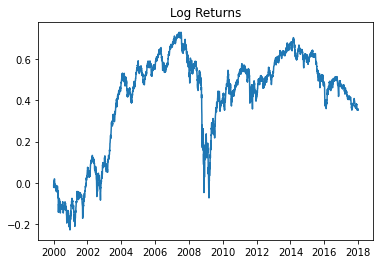

In [184]:
dates, perfs = execute_strategy(
    weight_function = construct_uniform_weights, 
    start_date      = dtime(2000, 1, 1), 
    end_date        = dtime(2017, 12, 31)
)

plt.plot(dates, np.cumsum(perfs))
plt.title("Log Returns")
plt.show()